# Create spatial varying tau and max level for restoring
This code generates two spatial maps: rtau (reciprocal of tau; shoule be named "PT_RESTORE_RTAU") and the max level for restoring (should be named "PT_RESTORE_MAX_LEVEL", should be integer).

https://bb.cgd.ucar.edu/cesm/threads/how-to-write-a-restore-nc-file-in-forcing_pt_interior_nml.2865/#post-36194

In [1]:
import netCDF4 as nc
import regionmask
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

### Get lon/lat from some simultion

In [2]:
c_name = 'C_128cores'
c_year = '0001'
with xr.open_mfdataset('/data/rose_scr/yl528729/cesmruns/'+c_name+'/run/'+c_name+'.pop.h.'+c_year+'-01.nc', chunks={'time': 3}, combine='by_coords') as ds:    
    TLONG_da             = ds['TLONG'] # "array of t-grid longitudes" # (nlat, nlon)
    TLAT_da              = ds['TLAT'] # "array of t-grid latitudes" # (nlat, nlon)
    z_t_da               = ds['z_t'] # [cm] # "depth from surface to midpoint of layer"

In [3]:
default_tau    = 3650. # float
default_maxl   = 100 # integer
tau            = np.full(TLONG_da.shape, default_tau) # [days]
maxl           = np.full(TLONG_da.shape, default_maxl)
filename       = 'TAU_GLOB10Y_NA1M_LBD5D'

modify_NA_tau  = True
modify_LBD_tau = True
save_file      = True # True if you do want to save the file. False if you just wanna get the data


tau_NA         = 30.
tau_LBD        = 5.

In [4]:
basins          = regionmask.defined_regions.natural_earth.ocean_basins_50
mask            = basins.mask(TLONG_da, TLAT_da)

if modify_NA_tau:
    mask_NA            = ((mask==2)+(mask==62)+(mask==22)+(mask==100)+(mask==57)+(mask==19)+(mask==33)+(mask==34)+\
                          (mask==84)+(mask==89)+(mask==101)+(mask==102)+(mask==37)+(mask==43)+(mask==44)+(mask==72)+(mask==76)+(mask==77)+(mask==103))*(TLAT_da>30.)
    tau[mask_NA==True] = tau_NA
if modify_LBD_tau:
    mask_LBD           = (mask==19) 
    tau[mask_LBD==True]= tau_LBD
    mask_LBD_val       = mask_LBD.values

In [5]:
if save_file:
    out_filename = '/network/rit/home/yl528729/cesm1_2_1/input_made/'+filename+'.nc'
    print(out_filename)
    out_ds = nc.Dataset(out_filename, 'w', format='NETCDF4')
    out_ds.createDimension('nlat', TLAT_da.shape[0])
    out_ds.createDimension('nlon', TLONG_da.shape[1])

    TLONG     = out_ds.createVariable('TLONG', 'd', ('nlat','nlon'))
    TLAT      = out_ds.createVariable('TLAT', 'd', ('nlat','nlon'))
    rtau_out  = out_ds.createVariable('PT_RESTORE_RTAU', 'd', ('nlat','nlon'))
    maxl_out  = out_ds.createVariable('PT_RESTORE_MAX_LEVEL', 'i', ('nlat','nlon'))
    rtau_out[:] = 1./tau
    maxl_out[:] = maxl
    out_ds.close() 

/network/rit/home/yl528729/cesm1_2_1/input_made/TAU_GLOB10Y_NA1M_LBD5D.nc


In [ ]:
# plt.contourf(1./tau)
# plt.colorbar()

XX=(tau!=5.)
plt.contourf(XX)
plt.colorbar()

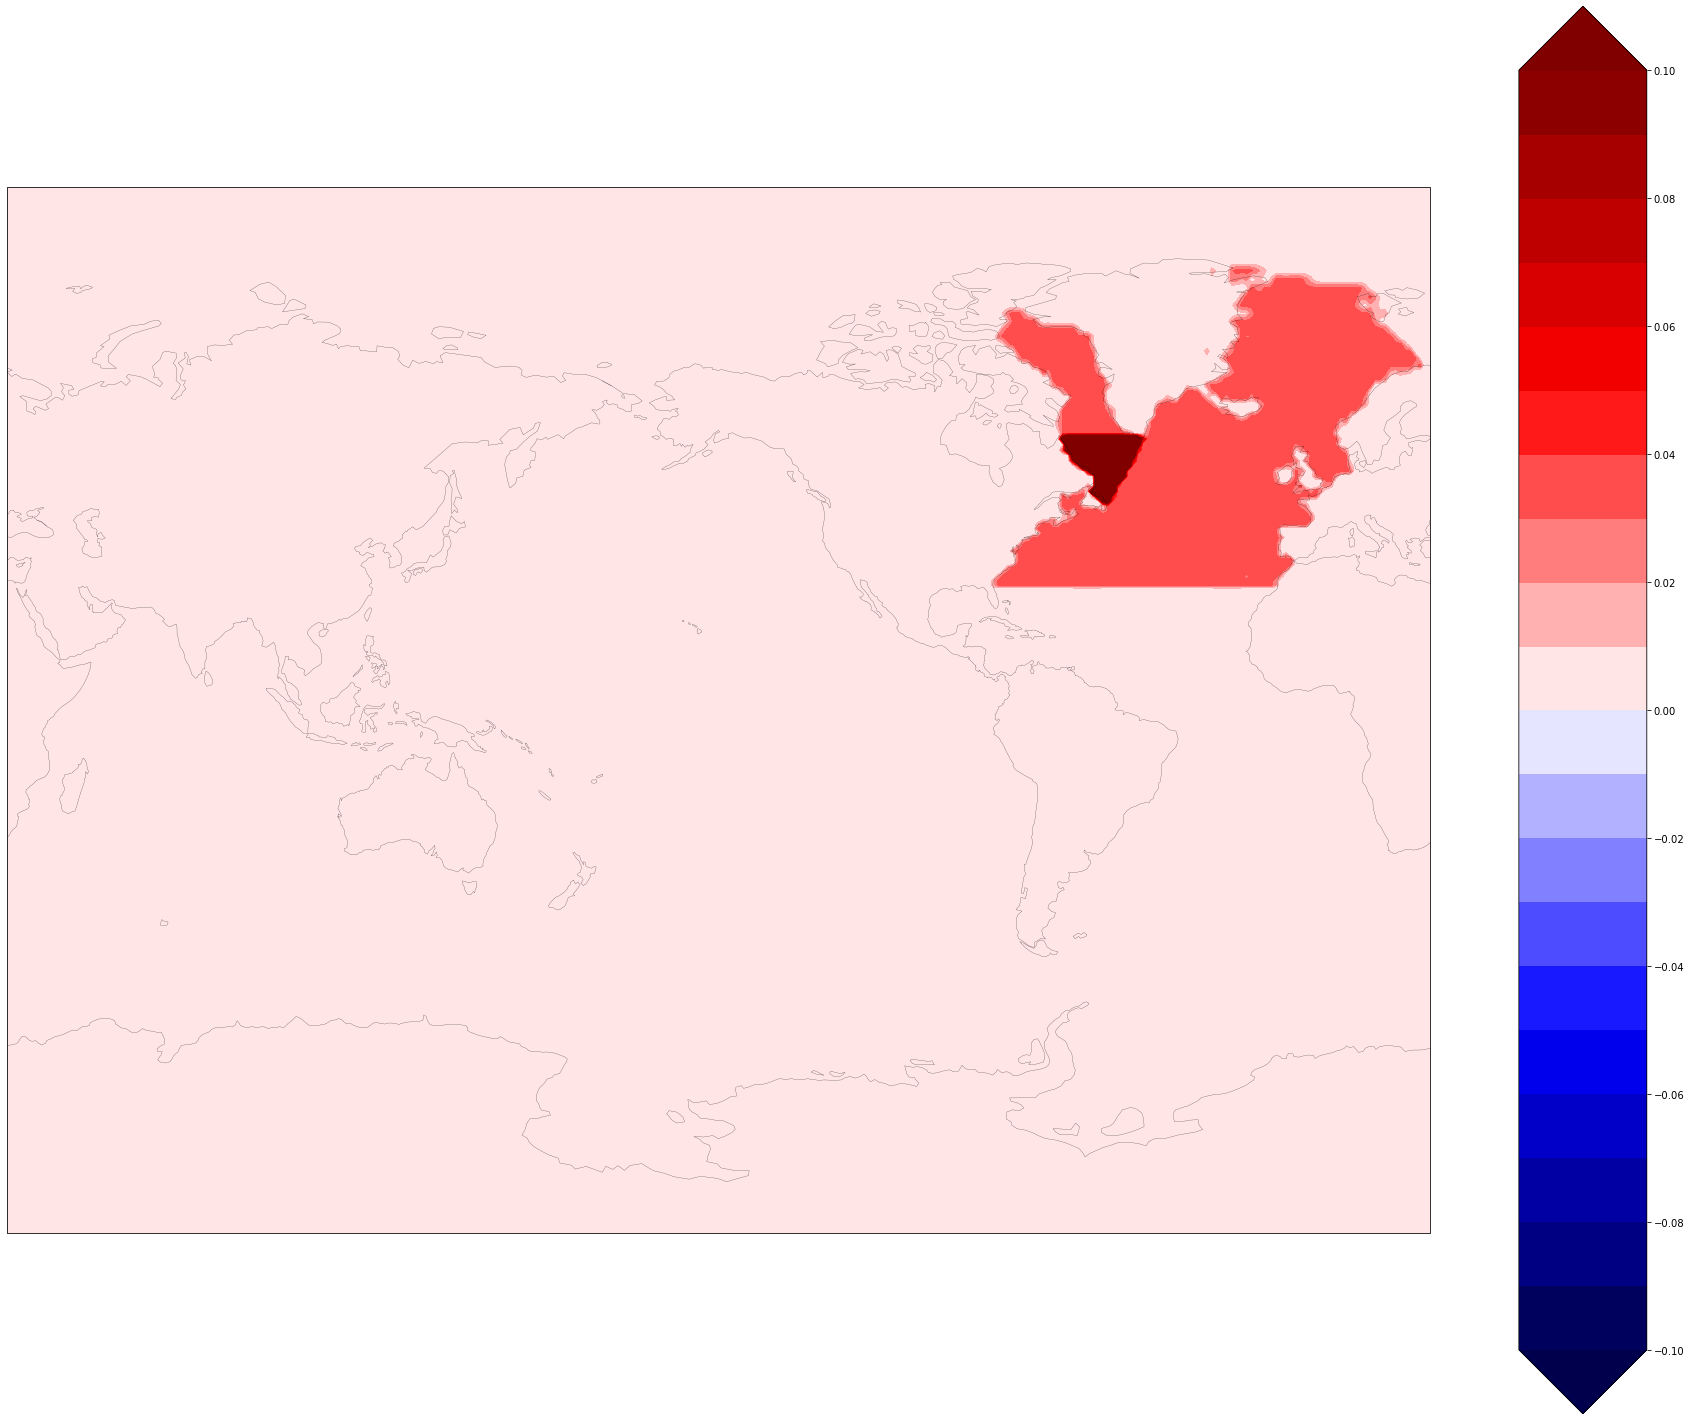

In [6]:
def quickplot(xC, xC2, xV, xU, xT, xT2, xF): # non-uniform colorbar        
    plot_lon = f09_lon
    plot_lat = f09_lat
    plot_var = xV.copy()  
    levels   = np.arange(-5,5.1,0.5)*xC+xC2
    projection = ccrs.Miller(central_longitude=210)
    fig = plt.figure(figsize=(25,20))
    ax  = plt.axes(projection=projection)
#     ax.set_extent((240, 390, 0, 90), crs=ccrs.PlateCarree())
    plot_lon_out = plot_lon + 30.
    plot_var_out = np.roll(plot_var, -24, axis=1) # f09_lon[24]=30.00
    x, y                       = np.meshgrid(plot_lon_out,plot_lat)     
    cs    = plt.contourf(x,y, plot_var_out, levels=levels, cmap="seismic", extend='both', transform=ccrs.PlateCarree())        
    cb    = plt.colorbar(cs, ticks=levels[0::2], drawedges=False, aspect=10, spacing="uniform")
    cb.ax.set_title(xU, fontsize=10)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.2, zorder=1) # change zorder = 3 if you want to put the land on top
    plt.suptitle(xT, fontsize=14, x=0.5, y=0.9)
    plt.title(xT2, fontsize=10)
    plt.tight_layout();
#     plt.savefig('/network/rit/home/yl528729/figs/'+xF+'.svg',transparent=True)  
import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeature
with xr.open_dataset('/network/rit/home/yl528729/f09_g17_grid.nc') as ds:
    f09_lon = ds['f09_lon'].values
    f09_lat = ds['f09_lat'].values
grid_in    = {'lon': TLONG_da, 'lat': TLAT_da} 
grid_out   = {'lon': f09_lon, 'lat': f09_lat}
regridder  = xe.Regridder(grid_in, grid_out, 'bilinear', periodic=True, ignore_degenerate=True)
# mask_NA = ((mask==2)+(mask==62)+(mask==22)+(mask==100)+(mask==57)+(mask==19)+(mask==33)+(mask==34))*(TLAT_da>30.)
# quickplot(0.2,0.,regridder(mask_NA.values),'','','','x')
quickplot(0.02,0.,regridder(1./tau),'','','','x')

In [ ]:
plt.figure(figsize=(40,30))
basins.plot(add_label=True, add_ocean=True);
plt.savefig('basin.svg')